In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import json

# Preparing dataset

In [2]:
!gdown "19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t"
!gdown "1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t
To: /content/Dataset.zip
100% 845M/845M [00:03<00:00, 219MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t
To: /content/Patterns.zip
100% 271M/271M [00:03<00:00, 73.0MB/s]


In [ ]:
!unzip /content/Dataset.zip -d Dataset
!unzip /content/Patterns.zip -d Patterns

# Viewing images

In [85]:
img_name = "/content/Dataset/1645635195.07319.png"
json_name = img_name[:-3] + "json"

{'version': '4.6.0', 'flags': {}, 'shapes': [], 'imagePath': '1645635195.07319.png', 'imageData': None, 'imageHeight': 2048, 'imageWidth': 2592, 'pattern': 'sama.tif'}


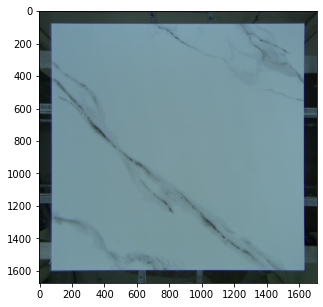

In [86]:
img = cv2.imread(img_name)

f = open(json_name, encoding="utf8")
data = json.load(f)
print(data)
f.close()

plt.figure(figsize=(5, 5))
plt.imshow(img[..., ::-1])

for shape in data["shapes"]:
  points = np.array(shape['points'])
  ind = list(np.arange(points.shape[0])) + [0]
  plt.plot(points[ind, 0], points[ind, 1], 'r.-')
  # plt.plot(points[-1:-3:-1, 0], points[-1:-3:-1, 1], 'r')

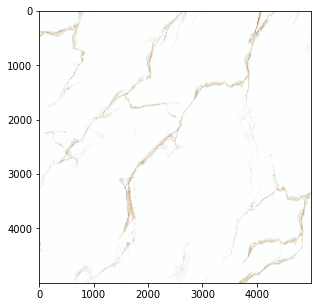

In [ ]:
pattern = cv2.imread('/content/Patterns/' + data['pattern'])

plt.figure(figsize=(5, 5))
plt.imshow(pattern[..., ::-1])

# Finding contours
We should use key points to match the pictures to patterns 

In [104]:
def remove_pattern_noise(img): 
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  ret,otsu_thresh = cv2.threshold(gray_img,127,200,cv2.THRESH_BINARY)

  kernel = np.ones((39, 39), np.uint8)

  closing = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE,
                            kernel, iterations=1)

  return cv2.Canny(np.uint8(closing), 80, 120)

output = remove_pattern_noise(img)

In [93]:
def find_vertices(im):
    contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    Minn, area = 0, 0
    for s in contours:
        area_hold = cv2.contourArea(s)
        if area_hold > area :
            Minn = s
            area = area_hold

    return cv2.approxPolyDP(Minn, 0.01*cv2.arcLength(Minn,True),True)

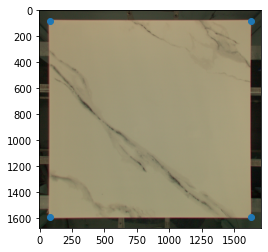

In [94]:
vertices = find_vertices(output)
plt.imshow(img)
plt.scatter([x[0][0] for x in vertices], [x[0][1] for x in vertices])

In [100]:
#save all image files and json files separately to list
import glob

input_dir = "/content/Dataset/"
label_dir = "/content/Labels/"

images_path_list = sorted(glob.glob(input_dir + "*.png") + glob.glob(input_dir + "*.jpg") + glob.glob(input_dir + "*.bmp"))
ann_list = sorted(glob.glob(input_dir + "*.json"))

308

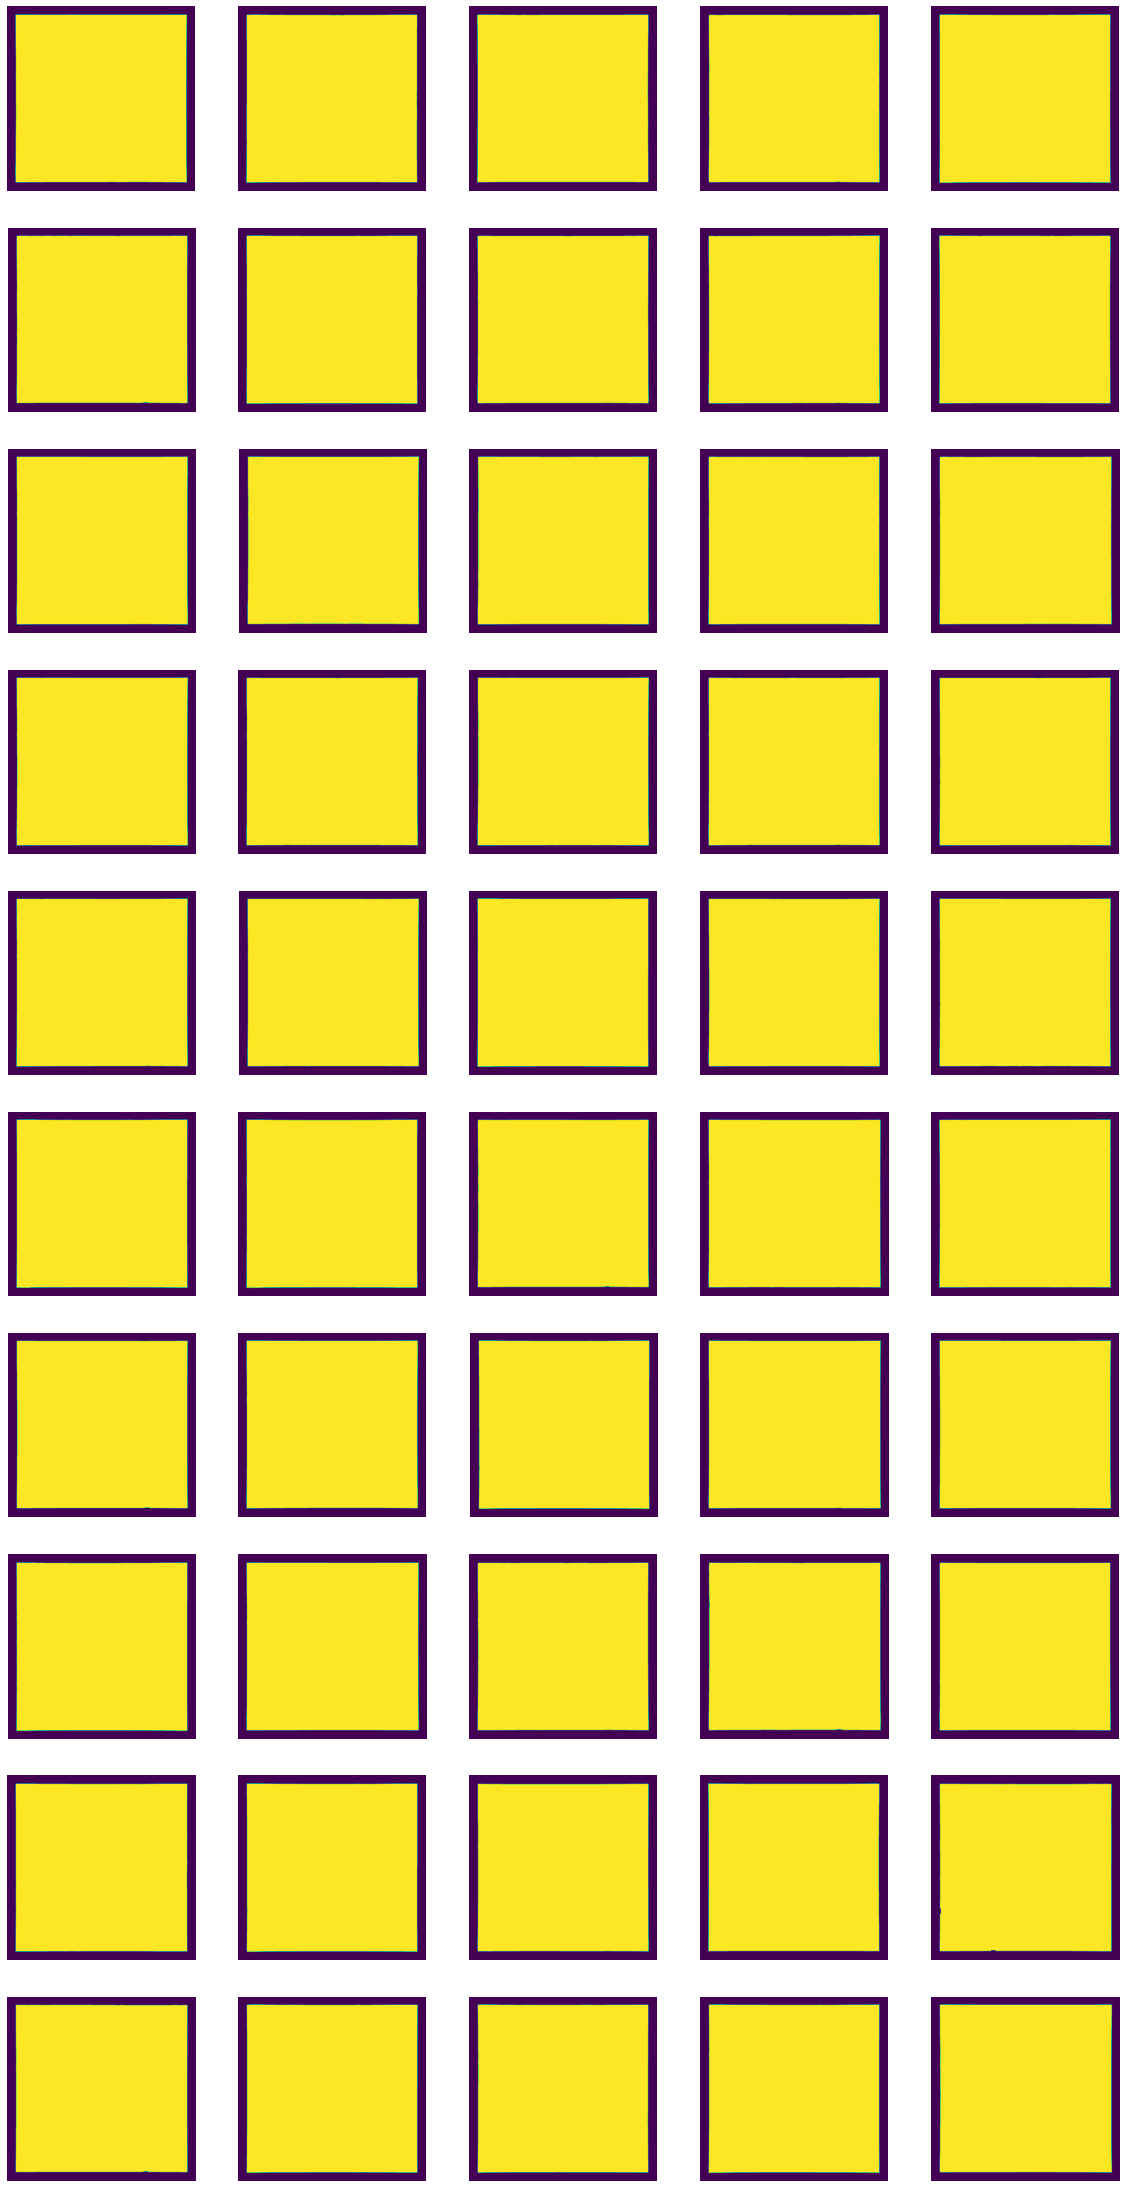

In [110]:
# Check that our operations work on good amount of pictures
import time

f, axarr = plt.subplots(10, 5, figsize=(20, 40))

for i in range(0,10):
  for j in range(0,5):
    img_name = images_path_list[i*5 + j]

    img = cv2.imread(img_name)

    edges = remove_pattern_noise(img)

    axarr[i,j].imshow(edges)
    axarr[i,j].axis('off')

plt.show()

# Crop picture

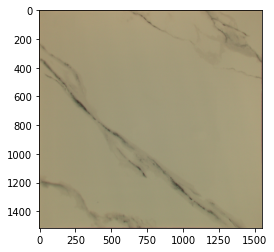

In [95]:
# Trying to apply transforms based on finding contours
import math

def crop_out(im, vertices):
    width_AD = math.dist(vertices[0][0],vertices[3][0])
    width_BC = math.dist(vertices[1][0],vertices[2][0])
    maxWidth = max(int(width_AD), int(width_BC))

    height_AB = math.dist(vertices[0][0],vertices[1][0])
    height_CD = math.dist(vertices[2][0],vertices[3][0])
    maxHeight = max(int(height_AB), int(height_CD))

    target = np.float32([[0, 0],[0, maxHeight - 1],[maxWidth - 1, maxHeight - 1],[maxWidth - 1, 0]])

    transform = cv2.getPerspectiveTransform(np.float32([vertices[0][0], vertices[1][0], vertices[2][0], vertices[3][0]]), target)  # get the top or bird eye view effect
    return cv2.warpPerspective(im, transform, (maxWidth, maxHeight))

cropped = crop_out(img, vertices)

plt.imshow(cropped)

# Histogram matching

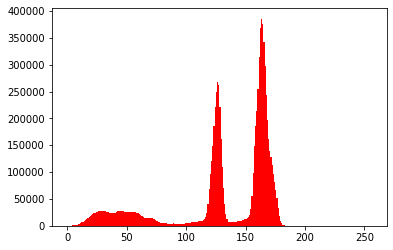

In [ ]:
# Histogram of an image
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.show()

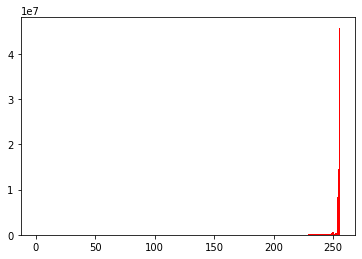

In [ ]:
# Histogram of pattern
pat = cv2.imread("/content/Patterns/AYLIN.tif")
plt.hist(pat.flatten(),256,[0,256], color = 'r')
plt.show()

In [ ]:
from skimage import exposure

def histogram_matching(img, pattern):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray_pat = cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)

  img_equ = cv2.equalizeHist(gray_img)
  pat_equ = cv2.equalizeHist(gray_pat)

  matched = exposure.match_histograms(img_equ , pat_equ)
  return matched

  # plt.hist(matched.flatten(),256,[0,256], color = 'r')
  # plt.show()

# Making image and pattern similar

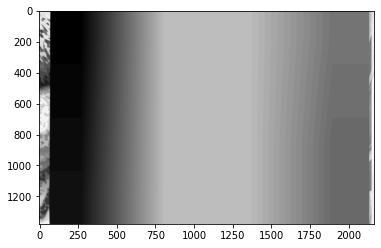

In [ ]:
# Hist matching and clahe
matched = histogram_matching(cropped, pattern)

clahe = cv2.createCLAHE(clipLimit=20.0, tileGridSize=(4,4))
clh = clahe.apply(np.uint8(matched))

plt.imshow(clh, cmap = 'gray')

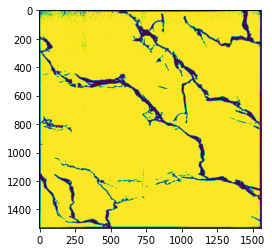

In [ ]:
ret,otsu_thresh = cv2.threshold(clh,40,220,cv2.THRESH_BINARY)
plt.imshow(otsu_thresh)

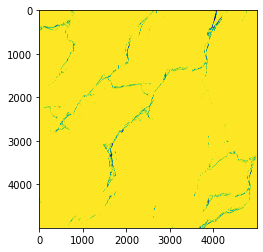

In [ ]:
gray_pattern = cv2.cvtColor(pattern, cv2.COLOR_BGR2GRAY)
ret,otsu_thresh = cv2.threshold(gray_pattern,200,220,cv2.THRESH_BINARY)
plt.imshow(otsu_thresh)

In [ ]:
plt.imshow()

# Subtraction 
pattern from image

# What network to use ??


# May be used later
Delete it if they didn't .

In [ ]:
MIN_MATCH_COUNT = 10

sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gray_pat,None)
kp2, des2 = sift.detectAndCompute(gray_img,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = gray_pat.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(gray_pat,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(gray_pat,kp1,gray_img,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()